In [1]:
'''
Read reviews from a JSON-formatted file into an array.
'''
import json
import string
import re
import keras
import numpy as np
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score

lines = [];
num_pos = 0;
num_neg = 0;
num_total = 75000;

with open('data/yelp_academic_dataset_review.json', 'r',encoding='utf8') as f:
    for line in f:
        if (len(lines) >= (num_total * 2)):
            break;

        json_info = json.loads(line);

        if json_info['stars'] > 3:
            if num_pos > num_total:
                continue;
            num_pos = num_pos + 1;
        elif json_info['stars'] < 3:
            if num_neg > num_total:
                continue;
            num_neg = num_neg + 1;
        else:
            continue;

        lines.append(json.loads(line));

'''
Separate line data into reviews and labels
'''
reviews = [line['text'] for line in lines];

stars = [line['stars'] for line in lines];
labels = ['1' if star > 3 else '0' for star in stars];

'''
Clean each document by removing unnecesary characters and splitting by space.
'''

Using TensorFlow backend.


'\nClean each document by removing unnecesary characters and splitting by space.\n'

In [2]:
print(reviews[0])
print(stars[0])
print(labels[0])

The pizza was okay. Not the best I've had. I prefer Biaggio's on Flamingo / Fort Apache. The chef there can make a MUCH better NY style pizza. The pizzeria @ Cosmo was over priced for the quality and lack of personality in the food. Biaggio's is a much better pick if youre going for italian - family owned, home made recipes, people that actually CARE if you like their food. You dont get that at a pizzeria in a casino. I dont care what you say...
2
0


In [3]:
def clean_document(doco):
    punctuation = string.punctuation + '\n\n';
    punc_replace = ''.join([' ' for s in punctuation]);
    doco_clean = doco.replace('-', ' ');
    doco_alphas = re.sub(r'\W +', ' ', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace);
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')]);
    doco_clean = doco_clean.split(' ');
    doco_clean = [word.lower() for word in doco_clean if len(word) > 0];

    return doco_clean;


In [5]:
# Generate a cleaned reviews array from original review texts
review_cleans = [clean_document(doc) for doc in reviews];
sentences = [' '.join(r) for r in review_cleans]
sentences[0]

'the pizza was okay not the best i ve had i prefer biaggio s on flamingo fort apache the chef there can make a much better ny style pizza the pizzeria cosmo was over priced for the quality and lack of personality in the food biaggio s is a much better pick if youre going for italian family owned home made recipes people that actually care if you like their food you dont get that at a pizzeria in a casino i dont care what you say'

In [6]:
# Use a Keras Tokenizer and fit on the sentences
tokenizer = Tokenizer();
tokenizer.fit_on_texts(sentences);
reviews_encoded = np.array(tokenizer.texts_to_sequences(sentences));
' '.join(map(str,reviews_encoded[0]))

'1 178 6 537 19 1 104 3 86 24 3 1565 21005 29 21 4439 6276 7334 1 660 33 66 119 5 121 128 2184 612 178 1 4741 5475 6 94 618 9 1 215 2 816 8 2532 10 1 32 21005 29 11 5 121 128 471 40 7611 114 9 760 279 1560 193 124 4759 106 13 286 232 40 18 53 56 32 18 927 51 13 25 5 4741 10 5 1011 3 927 232 64 18 151'

In [7]:
sequence_dict = tokenizer.word_index;
# reverse - index to word
word_dict = dict((num, val) for (val, num) in sequence_dict.items());

In [8]:
#for i,(a,b) in enumerate(zip(reviews_encoded,text_sequences)):
#    if (a!=b):
#        print(review_cleans[i])

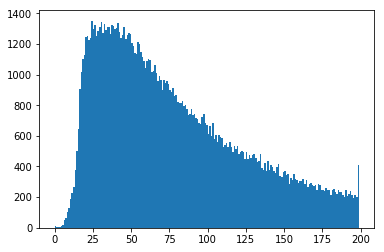

In [9]:
# Plot a Histogram of length of reviews
lengths = [len(x) for x in reviews_encoded];
plt.hist(lengths, bins=range(200))
plt.show()

In [10]:
# Truncate and Pad reviews at a Maximum cap of 60 words.
max_cap = 60;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

In [11]:
' '.join(list(map(lambda x: word_dict[x], X[0])))

'the pizza was okay not the best i ve had i prefer biaggio s on flamingo fort apache the chef there can make a much better ny style pizza the pizzeria cosmo was over priced for the quality and lack of personality in the food biaggio s is a much better pick if youre going for italian family owned home'

In [12]:
# Obtain a One-hot Y array for each review label.
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

Y

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [13]:
# Get a randomized sequence of positions to shuffle reviews
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

# Shuffle X and Y
X = X[random_posits];
Y = Y[random_posits];

In [14]:
# Divide the reviews into Training, Dev, and Test data.
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

X_train, Y_train = X[:train_cap], Y[:train_cap];
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap];
X_test, Y_test = X[dev_cap:], Y[dev_cap:]


In [15]:
model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
model.add(LSTM(100, return_sequences=True));
model.add(LSTM(100));
model.add(Dense(100, activation='relu'));
model.add(Dense(2, activation='softmax'));
print(model.summary());

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 60)            5966340   
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 100)           64400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 6,121,442
Trainable params: 6,121,442
Non-trainable params: 0
_________________________________________________________________
None


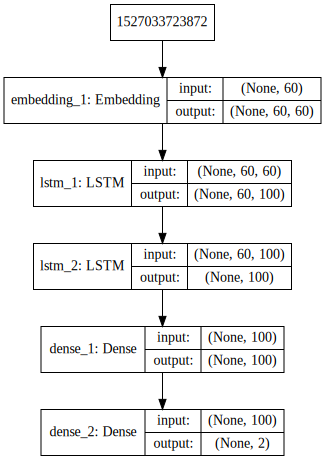

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [34]:
optimizer = Adam(lr=0.001, decay=0.0001);
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history = model.fit(X_train, Y_train, batch_size=128, epochs=3, validation_data=(X_dev, Y_dev))


Train on 127500 samples, validate on 12000 samples
Epoch 1/3
127500/127500 [==============================] - 236s 2ms/step - loss: 0.2599 - acc: 0.8927 - val_loss: 0.2234 - val_acc: 0.9113
Epoch 2/3
127500/127500 [==============================] - 236s 2ms/step - loss: 0.1669 - acc: 0.9347 - val_loss: 0.2144 - val_acc: 0.9131
Epoch 3/3
127500/127500 [==============================] - 236s 2ms/step - loss: 0.1228 - acc: 0.9531 - val_loss: 0.2348 - val_acc: 0.9128


In [35]:
# Obtain predictions
predictions = model.predict_classes(X_test)

# Convert Y_test to the same format as predictions
actuals = [0 if y[0] == 1 else 1 for y in Y_test];

# Use SkLearn's Metrics module
accuracy_score(predictions, actuals)

0.9122857142857143

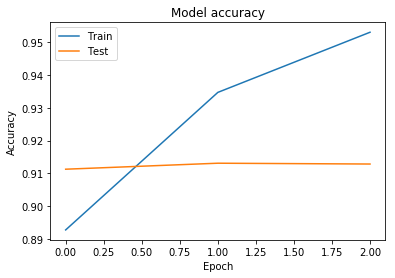

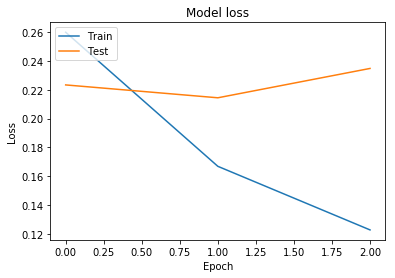

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()